# Goal and desired outcomes

Given the rich information from Amazon review dataset and product metadata, I focus on two questions: 

 - First, when reviewers like a certain product or dislikes a certain product, what do they like/dislike about? 

 - Second, what are the reviews that are most relevant to the product and thus helpful for potential users and manufacturers to read. 

To answer the two questions, I will need to do two types of analysis: firstly, I need to find all the positive comments (sentences) and negative comments (sentences) and discover the relevant product features or perspectives mentioned in these comments. secondly, I need to compute the relevance of review content to the product information. 

The analysis follows three steps:
    
- Exploratory data analysis; 
- Sentiment analysis to classify reviewers' opinions towards a certain product: positive, neutral or negative; 
- Extracting meaningful phrases from reviewer's comments and get a representative sentence around the phrase
- Calculate the similarity of each review text and the product metadata description

To make my analysis more understandable and efficient, I will use the review and metadata of sleep aid medine as an example. The analysis can be automated and adapted to other products as well.

In [119]:
%load_ext autoreload
%autoreload 2

## Exploratory data analysis

In [2]:
import pandas as pd
import numpy as np

In [3]:
# read in the sleep aid products review data
df=pd.read_csv('sleep_review.csv')

let's take a look at the dataset

In [4]:
print (df.head(5))

   Unnamed: 0      reviewerID        asin helpful  \
0           0  A3AUGQNG5EYQ1Y  B000053136  [0, 0]   
1           1  A2WI4GOCOOF3PK  B000053136  [0, 1]   
2           2  A3I6PVPLOWPPS2  B000053136  [1, 1]   
3           3  A31TSQ6L9VS073  B000053136  [0, 0]   
4           4   AF30W6VYOTF7H  B000053136  [1, 1]   

                                          reviewText  overall  \
0  Ok... so I got this because a friend recommend...      1.0   
1  Good product great taste and really works, arr...      5.0   
2  this stuff is really helpful for a toddler who...      5.0   
3  We bought this for our kidos on the advice fro...      4.0   
4  I have a 8 yr. old with "Down Syndrome". He is...      4.0   

                                             summary  \
0  Can't decide if I should dump the rest or just...   
1                                   Melatonin luquid   
2           strong smell, mixes well into dark juice   
3                                        Works great   
4         

As shown in the data cleaning section (link:), the dataset is a integration of the reviews' relevant information and products' metadata: 

- Columns including "reviewerID", "reviewText", "summary" and "overall" are relevant to the reviews; 
- columns such as "asin", "description" are originally from metadata database or derived variables from metadata. 

The sentiment analysis will use three columns: "overall", "reviewText" and "summary".  "Overall" is the rating, "reviewText" is the review text that a reviewer wrote about a product, and "summary" is a short phrase of sentence that summarize the reviewer's opinion.

I will start EDA with exploring these three columns. 

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

rating and corresponding number:

5.0    2301
4.0     786
3.0     526
1.0     335
2.0     318
Name: overall, dtype: int64

Histogram of rating:



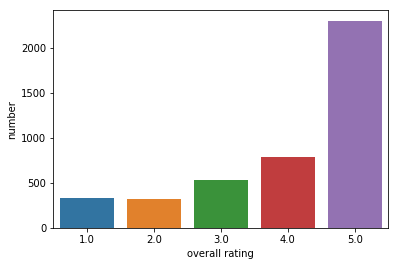

In [6]:
# distribution of overall rating
print ('rating and corresponding number:\n')
print (df.overall.value_counts())
print ('\nHistogram of rating:\n')
sns.countplot("overall", data=df)
plt.xlabel('overall rating')
plt.ylabel('number')
plt.show()

It shows that the overall rating is a integer between 1 and 5. Also, the number of review increases with rating, where majority of reviews have a rating of 5. 

The sentiment analysis will be done on each sentence rather a paragraph of review text as a whole, therefore, next I will examine the total number of sentences under each rating. 

First I calculate the number of sentences of each review text

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize

df["sent_number"]=df.reviewText.apply(lambda x:len(sent_tokenize(str(x))))

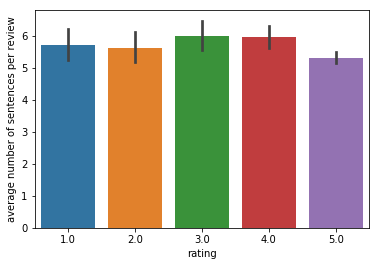

In [8]:
sns.barplot(y="sent_number", x='overall', data=df)
plt.ylabel('average number of sentences per review')
plt.xlabel('rating')
plt.show()

It shows that the average number of sentences per review is slightly high for intermediate rating, e.g. 3., but overall is quite similar among the five level of ratings: mostly around 5-6. 

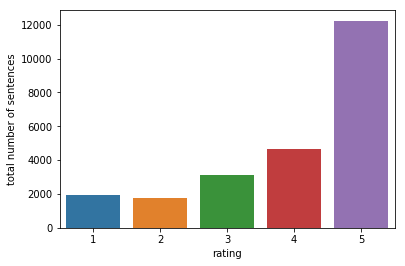

In [9]:
sns.barplot(x=[1,2,3,4,5], y=df.groupby('overall').agg({'sent_number':'sum'}).sent_number.values)
plt.ylabel('total number of sentences')
plt.xlabel('rating')
plt.show()

Therefore, the total number of sentences for each rating still largely driven by the number of reviews as shown earlier and increases as rating increases. This suggests that sentiment analysis may have a unbalanced class with more senteces from positive reviews. 

Now let's take a look at the summary. 

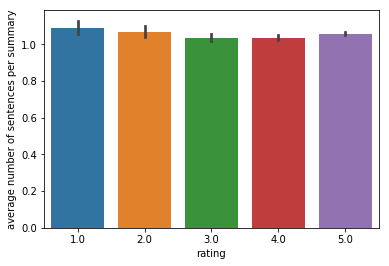

In [10]:
df["summary_length"]=df.summary.apply(lambda x:len(sent_tokenize(str(x))))

sns.barplot(y="summary_length", x='overall', data=df)
plt.ylabel('average number of sentences per summary')
plt.xlabel('rating')
plt.show()

The length of summary is consistently low for all ratings, just one sentences in most cases!

However, how a reviewer usually summarize a long review text into a sentence? Let's take a look at an example of review text, summary and overall rating.

In [11]:
print ("review text:\n",df.loc[0]['reviewText'], "\n")
print ("summary sentence:\n",df.loc[0]['summary'], "\n")
print ("rating=", df.loc[0]['overall'])

review text:
 Ok... so I got this because a friend recommended melatonin to help me sleep at night. The first night I tried it I got a little relaxed, fuzzy sleeping feeling for maybe 5 minutes (I was already a little tired) and then BAM I felt hyper. Every other time I tried it since then? Nada. I might as well be drinking water.As for taste... I love me some straight up spirits, so the alcoholy part didn't bother me. It reminded me a bit of NyQuil meets a bit of, I don't know.. some sort of flavored vodka. I'm certainly drank worse things. 

summary sentence:
 Can't decide if I should dump the rest or just keep using it 

rating= 1.0


The reviewer rated the product 1 star, which is the lowest one. The review text gives more details of the user's experience, negative and positive and something in between. For example, "The first night I tried it I got a little relaxed" apparently is spoken in a relatively positive fashion. "I love me some straight up spirits, so the alcoholy part didn't bother me." is in between positive and negative. The taste does not bother the user although the user did not complement on it. "then BAM I felt hyper" may suggest a negative experience. It is therefore inappropriate to see the whole review text as being negative, although the overall rating is 1. 

However, the summary sentence does more straighforwardly reflect the user's feeling (mainly negative) than the review text.

Let's take a look at another example for which the rating is 4 or 5. 

In [12]:
print ("review text:\n",df.loc[5]['reviewText'], "\n")
print ("summary sentence:\n",df.loc[5]['summary'], "\n")
print ("rating=", df.loc[5]['overall'])

review text:
 I have trouble falling asleep, and I have used ambien, Tylenol PM, and Unisom.  All work; however, they leave me a little groggy in the morning.  I had very little success with melatonin in the pill form.  I heard about the liquid form, ordered it, and I am having much better results with it.....generally falling asleep within 20 - 30 minutes after head hits the pillow. 

summary sentence:
 Better than pills 

rating= 4.0


It shows that overall the user was happy with the product. However, several sentences are not relevant to the product such as "I have trouble falling asleep, and I have used ambien, Tylenol PM, and Unisom.". These sentences are plain fact without strong polarity. These are the sentences that from which we cannot extract any opinions from. 

These two examples suggest that it is inappropriate to treat the whole review text as either entirely positive opinions or negative opinions only based on their rating. Instead, what I want to find are a subset of sentences from the review text with strong polarity and mostly likely contain some opinions. 

This also suggest that I cannot collect the review texts as training data for sentiment analysis only based on their rating. Therefore, in the next section, I will collect the sentences that are mostly likely opinions to be training set for sentiment analysis. 

# Sentiment Analysis

As discussed above, a long review text may not focus on user's experience with the product. Therefore, to get a good training set for sentiment analysis, I collect the review text with no more than 2 sentences. These review text more likely to focus on user's experience and has clearer polarity as compared to the longer ones.

Another useful set of text data is the summary. As shown above, the summary usually has only one sentence which are the best representative of the user's experiences. 

Therefore, to construct the training, validation and test data, I collect the short reivew text (<=2 sentences) and all of the summary sentences. 

Short review text and summary with rating at 4 or 5 are considered positive opinions and will be labeled as '1', while short review text and summary with rating at 1 or 2 are considered as negative opinions will be labeled as '0'. 

In [13]:
# get the summary sentences for training, validation data
df_1=df[(df['overall'].isin([5,4,2,1]))][['overall', 'summary']]
# get the rows where the review text with no more than 2 sentences and select the summary sentences and review text for training, validation data
df_2=df[(df['overall'].isin([5,4,2,1])) & (df["sent_number"].isin([1,2]))][['overall', 'reviewText']]

In [14]:
# rename the columns to sentences
df_1=df_1.rename(columns={'summary':'sentences'})
df_2=df_2.rename(columns={'reviewText':'sentences'})

# concatenate the two dataframe by row into the dataset for training-validation-testing, df_tvt
df_tvt=pd.concat([df_1, df_2], axis=0).dropna()
df_tvt.index=range(df_tvt.shape[0])

# create label from the rating
df_tvt['label']=df_tvt['overall'].map({5:1,4:1,2:0,1:0})

Let's look at the integrated dataset that will be used for training, validation and test

In [15]:
df_tvt.head(5)

,overall,sentences,label
0,1.0,Can't decide if I should dump the rest or just...,0
1,5.0,Melatonin luquid,1
2,5.0,"strong smell, mixes well into dark juice",1
3,4.0,Works great,1
4,4.0,It really does help!,1


How many positive sentences and negative sentences do I have?

In [16]:
df_tvt['label'].value_counts()

1    3755
0     777
Name: label, dtype: int64

let's take a look the size of the training-validation set as compared to the rest unlabeled data (in terms of number of sentences)

In [17]:
N=df['sent_number'].sum()+len(df['summary'])

print ('training-validation set {}% of total data'.format(round(100*df_tvt.shape[0]/N, 2)))

training-validation set 16.17% of total data


It shows that the postive sentences are four times more than the negative sentences. Again this is because that generally the number of reviews increases as rating increases (as shown earlier). This indicates an unbalanced class. However, if this is what the rest of data looks like, the imbalance is also feature of the data. So I do not do oversampling or undersampling and begin with this unbalanced dataset. 

### Data preprocessing

Before sentiment analysis, the raw text data needs to be preprocessed. Here I preprocess the data in following steps:

- separate "not" as a single word. For example: don't -> do not, won't -> will not. This needs to be done because 'not' is very important to distinguish positive opinions and negative opinions, and techniques such as stemming and lemmitizing does not seperate it from these abbreviated words. 

- spelling correction. For example, amazzzzing -> amazing. 

- remove punctuation.

- lemmatization

I wrote a customized preprocessor that can transform a raw text message in above steps and save it in the Preprocess.py file in the same folder. Here I import it. 

In [18]:
from Preprocess import Preprocessor

for example, the text "It is amazzzzing! I cant believe that I fell asleep within mins!"

In [19]:
text="It is amazzzzing! I cant believe that I fell asleep within mins!"
Preprocessor(text)

'amazing not believe fell asleep within min'

It is not perfectly preprocessed since word "mins" cannot be detected as an abbreviation of 'minutes', but it does the job to clean the data to the extent that features such as words and ngrams are ready to be extracted. 

Preprocess the raw sentences into text ready to extract features and train classifier:

In [20]:
df_tvt['text']=df_tvt['sentences'].apply(Preprocessor)

## Building a pipeline of feature selection and classification

### I. Train_test split

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X=df_tvt['text'].values
y=df_tvt['label'].values.astype(int)

X_train, X_test, y_train, y_test =  train_test_split(X,y,stratify=y,test_size=0.3, random_state=42)

### II. Building stages of pipeline and defining the parameter grid for following classifiers: 
- naive bayes
- support vector machine (SVM)
- random forest
- gradient boosting

In [22]:
# hyperparameters to tune for naive bayes
param_grid_nb = {'clf__alpha':[0.1, 1, 10]}

# hyperparameters to tune for support vector machine
param_grid_svm = {
    'clf__C':[0.01, 0.1, 1, 10],
    'clf__kernel':['rbf','poly'],
    'clf__gamma':[0.01, 0.1, 1, 10]
}


# hyperparameters to tune for random forest
param_grid_rf = {
    'clf__n_estimators':[100, 500, 1000],
    'clf__max_features': [10, 'log2', 'sqrt'],
    'clf__max_depth':[8, 10, 40]
}

# hyperparameters to tune for gradient boosting
param_grid_gb = {
    'clf__n_estimators':[50, 100, 500],
    'clf__max_features': [20, 'log2', 'sqrt'],
    'clf__min_samples_leaf':[3, 10, 20],
    'clf__min_samples_split':[3, 5, 10]
}

# a dictionary for the parameter grids of each classifier with abbreviated name
# of the classifier as the key
param_grids={'nb':param_grid_nb, 
             'rf':param_grid_rf,
             'svm':param_grid_svm,
             'gb':param_grid_gb}

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

"""This block of codes tune each type of classifier and record the model with tuned
hyperparameters"""
# a  TfidfVectorizer
vect=TfidfVectorizer()

# a chi-square feature selector
selector=SelectKBest(score_func=chi2)

clfs={'nb':MultinomialNB(), 
      'rf':RandomForestClassifier(class_weight='balanced'),
      'svm':svm.SVC(class_weight='balanced'),
      'gb':GradientBoostingClassifier()}

'''tune the model using different ranges of ngrams
 for example, ngram=2 means using unigram and bigram, ngram=3 means using 
 unigram, bigram and trigrams
 
 It is varied because short grams may result in underfitting since 
 more meaningful phrases usually have more words, but long grams may 
 cause overfitting. Therefore, ngram range is varied to find the best balance
 between underfitting and overfitting'''

ngrams=[3,4,5]

tuned_models=dict() 
for model in clfs.keys():
    print ("now tuning model ", model)
    tuned_models[model]=list()
    clf = clfs[model]
    pipeline=Pipeline([('vect', vect),
                       ('select', selector),
                       ('clf', clf)])
    param_grid=param_grids[model]
    param_grid['select__k']=[100] # add the chi square feature selection parameter
    for ngram in ngrams:
        print ('\n    ngram range: 1-', ngram)
        param_grid['vect__ngram_range']=[(1,ngram)]
        grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid)   
        grid.fit(X_train,y_train)
        tuned_models[model].append(grid)

now tuning model  nb

    ngram range: 1- 3

    ngram range: 1- 4

    ngram range: 1- 5
now tuning model  rf

    ngram range: 1- 3

    ngram range: 1- 4

    ngram range: 1- 5
now tuning model  svm

    ngram range: 1- 3

    ngram range: 1- 4

    ngram range: 1- 5
now tuning model  gb

    ngram range: 1- 3

    ngram range: 1- 4

    ngram range: 1- 5


### III. Evaluate performance of tuned classifiers

I evaluate the tuned classifiers in following ways: 
    - precision, recall, F1 and accuracy of the classifier on the training data and test data
    - ROC curve and precision-recall curve 
To be able to evaluate them in multiple perspectives, I wrote my own functions that helps visualize the performance and choose the best classifier. They can be imported found in Metrics_report.py file in the same folder.

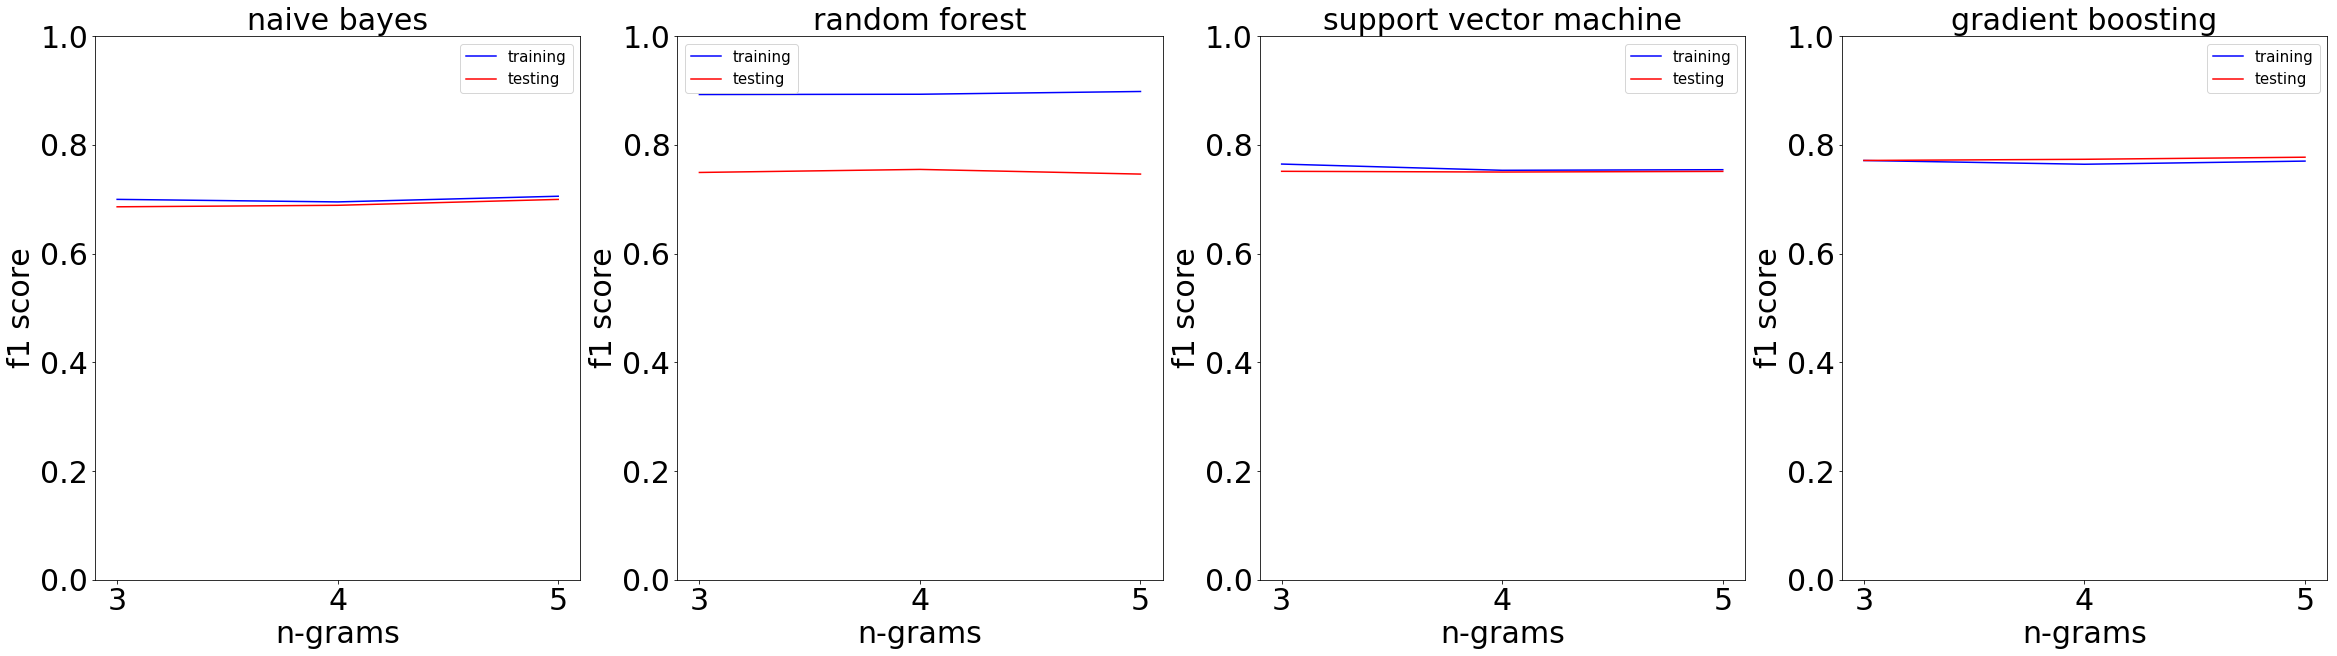

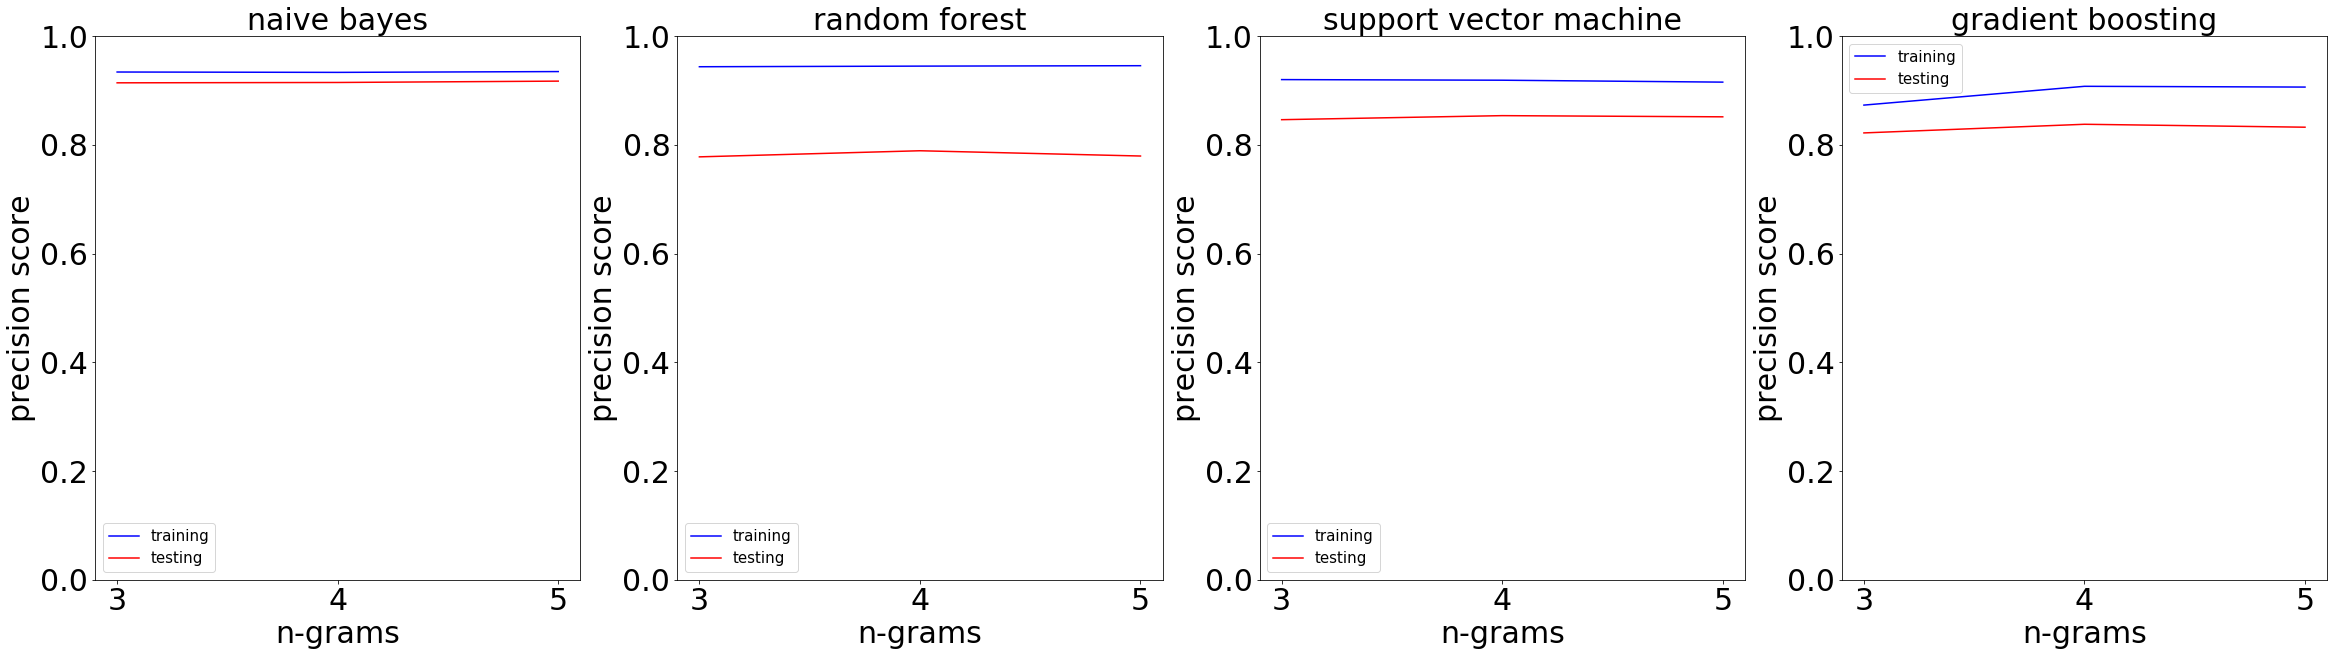

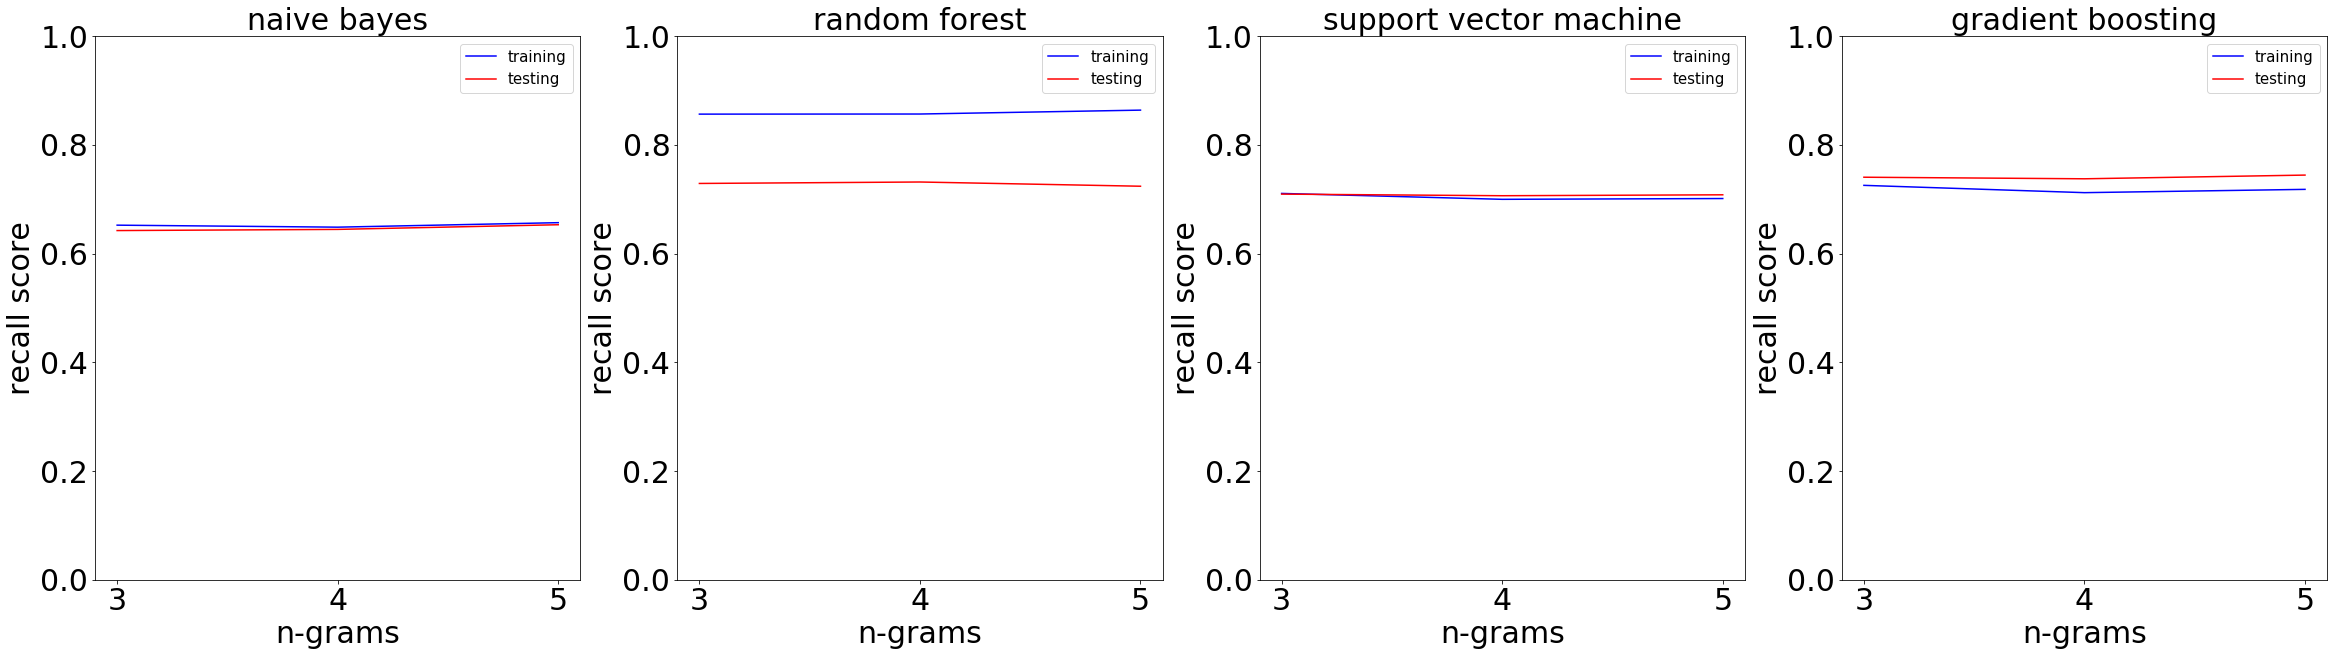

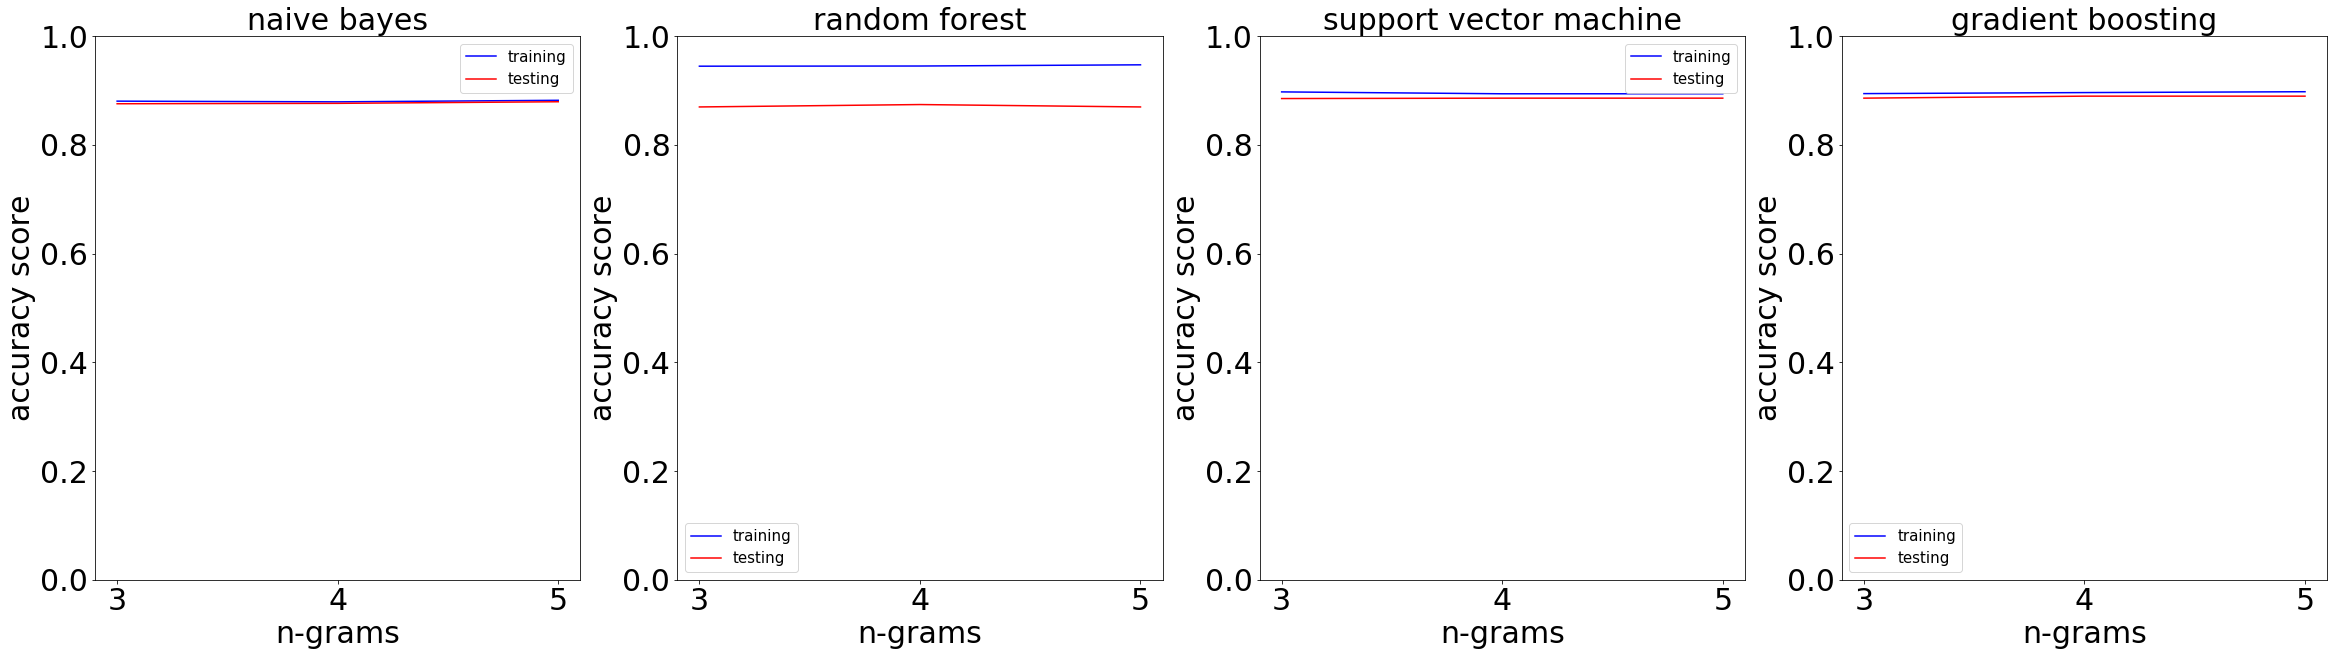

In [24]:
from Metrics_report import Performance_report, PR, ROC, PR_by_class

%matplotlib inline

model_names={'nb':'naive bayes',
             'rf':'random forest',
             'svm':'support vector machine',
             'gb':'gradient boosting'}
colors=['r', 'b', 'g', 'm']
for metric in ['f1', 'precision', 'recall', 'accuracy']:
    #plt.title(metric+' score')
    
    plt.figure(figsize=(40,10))

    for n,model in enumerate(clfs.keys()):
        plt.subplot(1,4,n+1)
        trainscores=list()
        testscores=list()
        for i, ngram in enumerate(ngrams):
            grid=tuned_models[model][i]
            training_metrics, testing_metrics=Performance_report(grid, X_train, y_train, X_test, y_test, printout=False)
            trainscores.append(training_metrics[metric])
            testscores.append(testing_metrics[metric])

        plt.title(model_names[model], size=30)
        plt.plot(ngrams, trainscores, label='training', color='b')
        plt.hold
        line,=plt.plot(ngrams, testscores, label='testing', color='r')
        
        plt.xlabel('n-grams', size=30)
        plt.ylabel(metric+' score', size=30)
        plt.xticks(ngrams,ngrams,size = 30)
        plt.yticks(size = 30)
        plt.legend(prop={'size': 15})
        plt.ylim(0,1)

It shows that overall SVM and gradient boosting perform better than random forest or naive bayes (where random forest has the poorest performance). 

Compared to the other two classifiers, both SVM and gradient boosting show the smaller gap between testing score (red) and training score (blue), indicating less overfitting. Given the small size of training-validation data (about 17%*0.7=12% of the whole data), it is important that the model does not overfit. 

Overall the score does not considerably change as ngram increases. In order to avoid underfitting, I choose 5 grams. 

In summary, the classifier I pick is Gradient boosting with 5-grams. 

In [31]:
tuned_clf=tuned_models['gb'][-1]

Let's take a closer look at the performance of the gradient boosting classifier

In [32]:
Performance_report(tuned_clf, X_train, y_train, X_test, y_test, printout=True)

Best: 0.871690 using {'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'select__k': 100, 'vect__ngram_range': (1, 5)}

------------------------------------------

the classification on training data are

confusion matrix:

[[ 242  302]
 [  22 2606]]
accuracy=0.8978562421185372

cohen kappa=0.5483991169481277

             precision    recall  f1-score   support

          0       0.92      0.44      0.60       544
          1       0.90      0.99      0.94      2628

avg / total       0.90      0.90      0.88      3172


------------------------------------------

the classification on test data are

confusion matrix:

[[ 122  111]
 [  39 1088]]
accuracy=0.8897058823529411

cohen kappa=0.5573051165980201

             precision    recall  f1-score   support

          0       0.76      0.52      0.62       233
          1       0.91      0.97      0.94      1127

avg / total       0.88      0.89      0.88      1360



({'accuracy': 0.89785624211853721,
  'cohen_kappa': 0.54839911694812771,
  'f1': 0.77024194471470264,
  'precision': 0.90640761118752866,
  'recall': 0.71824077804637843},
 {'accuracy': 0.88970588235294112,
  'cohen_kappa': 0.55730511659802007,
  'f1': 0.77740047400604939,
  'precision': 0.83259341376613016,
  'recall': 0.74450000190410182})

It shows that precision and recall are both higher for positive opinions (class 1) than for negative opinions (class 0), for both training data and testing data. 

In addition, recall of negative opinions is low for both testing (0.45) and training (0.42). 

These can be due to the unbalanced class: the amount of positive opinions is 5 times of that of negative opinions, so that the classifier is better at detecting positive ones than negative ones.

And how about the ROC curve and precision-recall curve?

In [ ]:
from Metrics_report import PR, ROC, PR_by_class

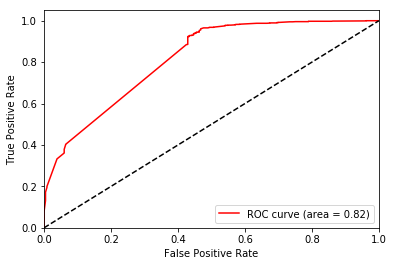

In [27]:
ROC(tuned_clf, X_test, y_test)

The ROC curve again shows that performance of gradient boosting on the test data. The area under the ROC curve (RUC) is 0.8, a considerable deviation from the random classification. 

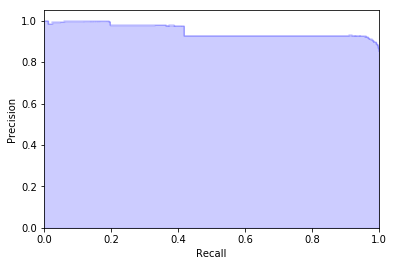

In [28]:
PR(tuned_clf, X_train, y_train)

The Precision-recall (PR) curve shows a good balance beteween precision and recall. 

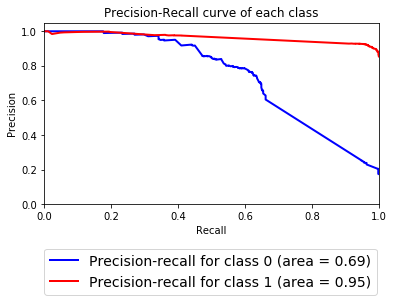

In [70]:
PR_by_class(tuned_clf, X_train, y_train)

The PR_curve for each class shows that the classifier performs better on class 1 (positive opinions) than on class 0 (negative opinions)

In [33]:
# save the model for later analysis
from sklearn.externals import joblib
joblib.dump(tuned_clf, 'clf.pkl')

['clf.pkl']

### IV. Find the optimal cutoff for most negative opinions and most positive opinions

The goal of the algorithm is to identify the postive comments and negative comments with relatively high confidence. We do not want to include false positive or false negative since information from these misclassified comments will mislead both the users and the manufactures. If considering it in terms of precision-recall tradeoff, precision matters more than recall in this condition and should be given higher weight when choosing the cutoff probability. 

The default cutoff probability is 0.5: sentences with score greater than 0.5 will be classified as positive and those with scores below 0.5 are predicted as negative. Varying this probability will result in enhanced precision for one class but reduced precision for the other. Therefore, to gurantee high precision for both classes, I seperately choose the cutoff probability for negative comments and postive comments. 

The cutoff probabilities would be higher than 0.5 for postive comments and lower than 0.5 for negative comments, so that the precision for both classes will be improved. This will cause sentences with scores between the two cutoff probabilities to not be classified. I call these sentences with smaller polarity and relatively neutral. These sentences are ones that there is higher uncertainty (lower confidence) associated with the postive/negative classification. 

However, only optimizing precision will harm the recall. So instead of using precision as the only metric, I use the combination of precision and recall as the metric and put more weight on precision. Fbeta score, is such a meature. It is the F1 score when precision and recall can have different weights. I set the weight of recall smaller than weight of precision (0.2 as compared to precision) and find the cutoff probaiblity at which Fbeta is highest for each class. 

I use the training data to calibrate the model and identify the optimized cutoff probabilities and test these cutoff probabilities on test data. 

In [35]:
from sklearn.metrics import precision_recall_fscore_support

def Fbeta_by_Threshold(grid, X, y, beta):
    colors=['blue', 'red']
    pred_probs=grid.predict_proba(X)
    y_pred=np.array([-1 for i in range(len(y))])
    thresholds=np.linspace(0,1,500)
    fbetas=np.empty([len(thresholds), 2])
    for i,t in enumerate(thresholds):
        y_pred[pred_probs[:,1]<t]=0
        y_pred[pred_probs[:,1]>t]=1
        
        precision,recall,fbeta,support=precision_recall_fscore_support(y, y_pred, beta=beta, labels=[0,1], average=None)
        fbetas[i, 0]=fbeta[0]
        fbetas[i, 1]=fbeta[1]
        #print (precision,recall,fbeta)
    optimal_cutoff=list()
    for i in range(2):
        optimal_cutoff.append(thresholds[np.argmax(fbetas[:, i])])
   
    return (tuple(optimal_cutoff))

In [103]:
# separatey optimizing Fbeta for each class
cutoff_0,_=Fbeta_by_Threshold(tuned_clf, X_train, y_train, 0.3)
_,cutoff_1=Fbeta_by_Threshold(tuned_clf, X_train, y_train, 0.1)

C:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
print ("after being optimized on Fbeta, the cutoff value for negative opinion is", cutoff_0)
print ("after being optimized on Fbeta, the cutoff value for positive opinion is", cutoff_1)
#optimal_cutoff_1

after being optimized on Fbeta, the cutoff value for negative opinion is 0.422845691383
after being optimized on Fbeta, the cutoff value for positive opinion is 0.915831663327


It shows that the optimal cutoff probability is 0.362 for class 0 (negative comments) and 0.869 for class 1(positive comments). It means that classifying all sentences with predicted score <0.362 as negative ones maximizes the fbeta for negative comments. And when classifying all sentences with predicted score >0.869 as positive maximizes the fbeta for positive comments. 

## Classifying Opinions

I use the chosen tuned classifier to predict the probability that each sentence of the reviewer's review text is positive.

### I. Data preprocessing of the rest of unlabeled review text

As discussed earlier, I only use review text with no more than 2 sentences for the training and validation. Sentences in all longer review text are still unlabeled, so I will use the tuned classifier to predict their polarity. 

Firstly, get a subset of the dataset with only long review text.

In [49]:
df_unlabel=df[(df['sent_number']>2) | (df['overall']==3)][['reviewerID', 'asin', 'reviewText', 'overall']]

column 'reviewID' and 'asin' are also kept since their combination can make a unique key id for each review text. 

In [50]:
df_unlabel['user_product_id']=df_unlabel['reviewerID']+'_'+df_unlabel['asin']
df_unlabel=df_unlabel.set_index('user_product_id')

Then I tokenize each long review text ('reviewText' column) into sentences and create a dataframe with 'user_product_id' column  one column for the rating ('overall') and one column for the sentence that a user wrote for a spefic product ('sentences'). 

In [51]:
from Text_to_sent import Text_into_sent

df_review=df_unlabel['reviewText'].apply(Text_into_sent).apply(pd.Series).stack()
df_review=df_review.reset_index().drop(['level_1'], axis=1).rename(columns={'level_0':'user_product_id', 0:'sentences'})
df_review=df_review.merge(df_unlabel[['overall']].reset_index(), left_on='user_product_id', right_on='user_product_id')

Let's take a look at the dataframe where sentences are to be classified

In [52]:
df_review.head(5)

,user_product_id,sentences,overall
0,A3AUGQNG5EYQ1Y_B000053136,Ok. so I got this because a friend recommende...,1.0
1,A3AUGQNG5EYQ1Y_B000053136,The first night I tried it I got a little rela...,1.0
2,A3AUGQNG5EYQ1Y_B000053136,Every other time I tried it since then?,1.0
3,A3AUGQNG5EYQ1Y_B000053136,Nada.,1.0
4,A3AUGQNG5EYQ1Y_B000053136,I might as well be drinking water.As for taste.,1.0


Notice that 'overall' is the overall rating of the whole review but not the polarity of the sentence. It is possible that a sentence tone is positive or neutral but from a review with rating of 1.

These raw sentences are then preprocessed by the customized Preprocessor.

In [53]:
df_review['text']=df_review['sentences'].apply(lambda x:str(Preprocessor(x)))

In [54]:
df_review.head()

,user_product_id,sentences,overall,text
0,A3AUGQNG5EYQ1Y_B000053136,Ok. so I got this because a friend recommende...,1.0,ok got friend recommended melatonin help sleep...
1,A3AUGQNG5EYQ1Y_B000053136,The first night I tried it I got a little rela...,1.0,first night tried got little relaxed fuzzy sle...
2,A3AUGQNG5EYQ1Y_B000053136,Every other time I tried it since then?,1.0,every time tried since
3,A3AUGQNG5EYQ1Y_B000053136,Nada.,1.0,nada
4,A3AUGQNG5EYQ1Y_B000053136,I might as well be drinking water.As for taste.,1.0,might well drinking water taste


In [55]:
df_review=df_review.dropna()

### II. Classification

Here I will use the classifier to predict the polarity of the sentences: negative, neutral or positive. 

The threshold of determining that a sentence falls into one category have been set according to earlier section: 

- sentences with probability <0.352 to be postive are assigned as negative comments;
- sentences with probability between 0.352 and 0.874 to be postive are assigned as neutral comments;
- sentences with probability greater than 0.874 to be postive are assigned as positive comments;

This may fail detect some positive comments and negative comments since the range of likelihood for neutral comments is quite wide (0.352-0.874). However, this is reasonable since the goal is to detect the strongly postive and negative comments rather than all likely negative and positive comments. Or I give precision a higher priority to recall in this context. 

In [56]:
pred_score=pd.DataFrame(tuned_clf.predict_proba(df_review['text'].values)[:,1], columns=['score'])

then merge the predicted score back to the dataframe of review sentences 

In [57]:
pred_score.index=df_review.index
df_pred=pd.concat([df_review, pred_score], axis=1)

Now the data has predicted score as one column

In [58]:
df_pred.head()

,user_product_id,sentences,overall,text,score
0,A3AUGQNG5EYQ1Y_B000053136,Ok. so I got this because a friend recommende...,1.0,ok got friend recommended melatonin help sleep...,0.943416
1,A3AUGQNG5EYQ1Y_B000053136,The first night I tried it I got a little rela...,1.0,first night tried got little relaxed fuzzy sle...,0.555015
2,A3AUGQNG5EYQ1Y_B000053136,Every other time I tried it since then?,1.0,every time tried since,0.882763
3,A3AUGQNG5EYQ1Y_B000053136,Nada.,1.0,nada,0.882763
4,A3AUGQNG5EYQ1Y_B000053136,I might as well be drinking water.As for taste.,1.0,might well drinking water taste,0.882763


Then I classify each sentence into postive, neutral or negative opinions using the two cutoff values: 0.22 and 0.91, and assign -1 to negative, 0 to neutral (not quite negative and not quite positive) and 1 to positive.

In [105]:
df_pred['label']=df_pred['score'].apply(lambda x:int(x>cutoff_0)-int(x<cutoff_1))

In [106]:
df_pred['category']=df_pred['label'].map({-1:'negative', 0:'neutral', 1:'positive'})

Let's take a look at the distribution of postive, neutral and negative comments for each rating

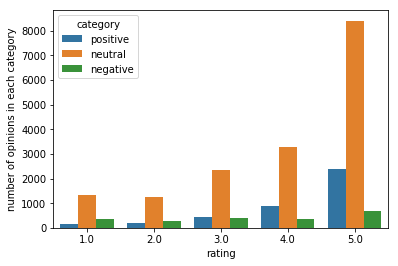

In [107]:
import seaborn as sns

sns.countplot(x='overall', hue='category', data=df_pred)
plt.xlabel('rating')
plt.ylabel('number of opinions in each category')
plt.show()

It shows that the majority of comments are categorized as neutral since their probability of being positive is between the two cutoff values. Their polarity is not as strong as the other comments. If we exclude these comments and only look at the strongly negative ones (label= -1) and strongly positive ones:

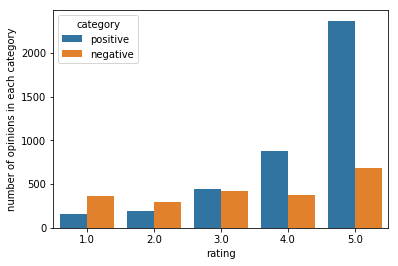

In [108]:
import seaborn as sns

sns.countplot(x='overall', hue='category', data=df_pred[df_pred['label']!=0])
plt.xlabel('rating')
plt.ylabel('number of opinions in each category')
plt.show()

The result looks reasonable: the fraction of negative comments decreases as rating increases while that of positive comments increases.

## Extract features and Representative sentences from reviews

After all negative opinions and positive opinions are classified, my next question is what are the meaningful phrases we can extract from these opinions? Or what the reviewers mentioned when they feel positive or negative about the product? 

### I. Data preprocessing

To answer this question, I first combine the dataframe with sentences predicted to be either negative or positive and train-validation-test data. 

In [109]:
# get the summary sentences for training, validation data
df_1=df[(df['overall'].isin([5,4,2,1]))][['overall', 'summary', 'reviewerID', 'asin']]
# get the rows where the review text with no more than 2 sentences and select the summary sentences and review text for training, validation data
df_2=df[(df['overall'].isin([5,4,2,1])) & (df["sent_number"].isin([1,2]))][['overall', 'reviewText', 'reviewerID', 'asin']]

In [110]:
# rename the columns to sentences
df_1=df_1.rename(columns={'summary':'sentences'})
df_2=df_2.rename(columns={'reviewText':'sentences'})

# concatenate the two dataframe by row
df_full=pd.concat([df_1, df_2], axis=0).dropna()
df_full.index=range(df_full.shape[0])

# create label from the rating
df_full['label']=df_full['overall'].map({5:1,4:1,2:-1,1:-1})

In [111]:
df_full['user_product_id']=df_full['reviewerID']+'_'+df_full['asin']

In [112]:
df_opinion=pd.concat([df_full[['user_product_id', 'sentences', 'label']], df_pred[df_pred['label']!=0][['user_product_id', 'sentences', 'label']]], axis=0)

In [113]:
df_opinion.head(5)

,user_product_id,sentences,label
0,A3AUGQNG5EYQ1Y_B000053136,Can't decide if I should dump the rest or just...,-1
1,A2WI4GOCOOF3PK_B000053136,Melatonin luquid,1
2,A3I6PVPLOWPPS2_B000053136,"strong smell, mixes well into dark juice",1
3,A31TSQ6L9VS073_B000053136,Works great,1
4,AF30W6VYOTF7H_B000053136,It really does help!,1


### II. Extracting phrases

A sentence is defined as a representative sentence if it contains at least one phrase a reviewer would use when comment on the product. An example of a representative sentence can be "It taste good and help me fall asleep", where "taste good" and "fall asleep" can be two phrases a reviewer use to comment on a sleep aid product. 

Therefore, the first important thing is to identify the meaningful phrases. There are different ways that peoeple use to define phrases. Here I use likelihood ratio test to determine the likelihood that two words form a phrase intead of appearing together by chance. 

First I will write two functions to extract the meaningful phrases: 

Function Likelihood_ratio_test: a function that return the ratio of likelihood that two words are assocaited with each other as a bigram over the likelihood that two words appear as a bigram by chance, given the bigram and the sparse matrix of word counts as the input.

In [115]:
from scipy.stats import binom

"""This is a function that return the ratio of likelihood that two words are 
assocaited with each other over the likelihood that two words appear 
together by chance
the arguments of this fuction:
bigram: a desired bigram that the likelihood ratio is calculated for
count_df: a countvectorized dataframe with unigrams and bigrams as the columns
order: whether the order that two words appear in a bigram matters. 
       It is set at true if we are looking at a specific order: "good taste" different from "taste good"
       and false if we do not care about the order: "good taste" same as "taste good"
"""

def Likelihood_ratio_test(bigram, count_df):
    w1=bigram.split(' ')[0]
    w2=bigram.split(' ')[1]

    n1=count_df[w1].sum()
    n2=count_df[w2].sum()
    
    n12=count_df[bigram].sum()
    
    # the number of single words
    N=count_df[[c for c in count_df.columns if ' ' not in c]].values.sum()
    # construct elements to calculate the likelihood ratio under null hypothesis: R0
    p00=float(n2)/N      # probability that w2 appears given appearance of w1 under null hypothesis
    p01=float(n2)/N       # probability that w2 appears without appearance of w1 under null hypothesis
    L0_w1_w2=binom.pmf(n12, n2, p00)           # likelihood that w1 and w2 appears togehter under null hypothesis
    L0_w1_no_w2=binom.pmf(n2-n12, N-n1, p01)    # likelihood that w2 appears WITHOUT w1 under null hypothesis
    R0=L0_w1_w2/L0_w1_no_w2                     # likelihood ratio under null hypothesis
    
    # construct elements to calculate the likelihood ratio under alternative hypothesis: R1
    p10=float(n12)/n1    # observed probability that w2 appears given appearance of w1
    p11=float(n2-n12)/(N-n1)  #observed probability that w2 appears without w1
    
    L1_w1_w2=binom.pmf(n12, n2, p10)            # likelihood that w1 and w2 appears togehter under alternative hypothesis
    L1_w1_no_w2=binom.pmf(n2-n12, N-n1, p11)    # likelihood that w2 appears WITHOUT w1 under alternative hypothesis
    R1=L1_w1_w2/L1_w1_no_w2                     # likelihood ratio under alternative hypothesis
    
    R_H1_H0=R1/R0                 # ratio of likelihood ratio of alternative hypothesis and null hypothesis
    return (R_H1_H0)


In [182]:
"""This is a function that construct a dataframe with one column as the first word of a bigram, 
   one column for the second word of a bigram and the likelihood ratio that the two words are associated with each other
   over the likelihood that they appear togher by chance. 
   
   The input is the text (or corpus) which will be used to construct the sparse matrix of counts of single words and bigrams
   
   The sparse matrix and a specific bigram will then be passed onto Likelihood_ratio_test function to calculate the likelihood ratio
"""
from sklearn.feature_extraction.text import CountVectorizer 

def Allletters(string):
    checkstring='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz '
    return (all([s in checkstring for s in string]))

def Bigrams_likelihoods_df(text):
    vect=CountVectorizer(ngram_range=(1, 2))
    count_matrix=vect.fit_transform(text)
    #print (count_matrix)
    count_df=pd.DataFrame(count_matrix.toarray())
    count_df.columns=vect.get_feature_names()
    count_df=count_df[[c for c in count_df.columns if Allletters(c)]]
    bigram_likelihoods=list()
    for c in count_df.columns:
        if ' ' in c:
            w1=c.split()[0]
            w2=c.split()[1]
            
            ratio=Likelihood_ratio_test(c, count_df)
            bigram_likelihoods.append((w1, w2, w1+' '+w2, ratio))
    likelihood_df=pd.DataFrame(bigram_likelihoods, columns=['w1', 'w2', 'bigram', 'likelihood'])
    return (likelihood_df)

In [244]:
import nltk
from nltk.corpus import stopwords
from nltk import ngrams, Tree
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import re

"""functions to extract meaningfuly phrases"""
"""
Pattern 1: <JJ|JJR|JJS>+<NN|NNS>               exp: good sleep, strong taste
Pattern 2: <JJ|JJR|JJS>+<NN|NNS>+<NN|NNS>      exp: long sleep hours
Pattern 3: <NN|NNS>+<NN|NNS>                   exp: sleep time
Pattern 4: NN/NNS+RB/RBR/RBP+JJ                exp: taste very strong (was or is removed because they are stop words)
Pattern 5: <RB|RBR|RBS>+<JJ>+<NN|NNS>          exp: highly recommended product
Pattern 6: <RB|RBR|RBS>+<VB|VBD|VBG|VBN|VBP|VBZ>  exp: quickly wake up
Pattern 7: <VB|VBD|VBG|VBN|VBP|VBZ>+<RB|RBR|RBS>  exp:sleep well
Pattern 8: <RB|RBR|RBS>+<VB|VBD|VBG|VBN|VBP|VBZ>+<RB|RBR|RBS>  exp:not sleep well
Pattern 9: <VB|VBD|VBG|VBN|VBP|VBZ>+<NN|NNS>      exp: have dreams
"""

def Phrase_set(terms):
    return (terms[[sum([s in t for t in terms])==1 for s in terms]])

def Chunk_to_term(chunked, label):
    terms=list()
    for node in chunked:
        if isinstance(node, Tree):               
            if node.label() == label:
                term=' '.join(node[n][0] for n in range(len(node)))
                terms.append(term)
    return (terms)

def Phrases(text):
    stop = set(stopwords.words('english'))-set(['not'])
    terms=list()
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    tagged=[tup for tup in tagged if tup[0] not in stop]
    
    try:
        chunk1=r"""Chunk: {<JJ|JJR|JJS>+<NN|NNS>}"""
        chunk2=r"""Chunk: {<JJ|JJR|JJS>+<NN|NNS>+<NN|NNS>}"""
        chunk3=r"""Chunk: {<NN|NNS>+<NN|NNS>}"""
        chunk4=r"""Chunk: {<RB|RBR|RBS>+<NN|NNS>+<NN|NNS>}"""
        chunk5=r"""Chunk: {<RB|RBR|RBS>+<JJJ|JJR|JJS>+<NN|NNS>}"""
        
        chunk6=r"""Chunk: {<NN|NNS>+<JJ|JJR|JJS>}"""
        chunk7=r"""Chunk: {<NN|NNS>+<RB|RBR|RBS>}"""
        chunk8=r"""Chunk: {<NN|NNS>+<RB|RBR|RBS>+<JJ|JJR|JJS>}"""
                
        chunk9=r"""Chunk: {<RB|RBR|RBS>+<VB|VBD|VBG|VBN|VBP|VBZ>}"""
        chunk10=r"""Chunk: {<VB|VBD|VBG|VBN|VBP|VBZ>+<RB|RBR|RBS>}"""
        chunk11=r"""Chunk: {<RB|RBR|RBS>+<VB|VBD|VBG|VBN|VBP|VBZ>+<RB|RBR|RBS>}"""
        
        chunk12=r"""Chunk: {<VB|VBD|VBG|VBN|VBP|VBZ>+<NN|NNS>}"""
        chunk13=r"""Chunk: {<RB|RBR|RBS>+<VB|VBD|VBG|VBN|VBP|VBZ>+<NN|NNS>}"""
        chunks=[chunk1,chunk2,chunk3,chunk4,chunk5,chunk6,chunk7,chunk8, 
                chunk9, chunk10, chunk11, chunk12,chunk13]
        for chunk in chunks:
            chunkParser = nltk.RegexpParser(chunk)
            chunked = chunkParser.parse(tagged)
            terms.extend(Chunk_to_term(chunked, 'Chunk'))
        return (Phrase_set(np.array(terms)))
    except Exception as e:
        print(str(e))  

"""function to preprocess the text data"""
def Preprocessor(x):
    stop = set(stopwords.words('english'))-set(['not'])
    """list of words with meaning of "not" and the form they are to be tranformed into"""
    transform={
        "doesn\'t":"does not",
        'dont':'do not',
     'don\'t':'do not',
     'donot':'do not',
     'cannot':'can not',
     'can\'t':'can not',
     'cant':'can not',
     'didnt':'did not',
     'didn\'t':'did not',
     'isnt':'is not',
     'isn\'t':'is not',
     'arent':'are not',
     'aren\'t':'are not',
     'arenot':'are not',
     'wasn\'t':'was not',
     'wasnt':'was not',    
      'wasnot':'was not',
     'weren\'t':'were not',
     'werent':'were not',
     'wont':'will not',
     'won\'t':'will not',
     'couldnt':'could not',
     'couldn\'t':'could not',
     'shouldnt':'should not',
     'shouldn\'t':'should not',
     'wouldn\'t':'would not',
     'wouldnt': 'would not',
     'hasnt':'has not',
     'hasn\'t':'has not',
     'havent':'have not',
     'haven\'t':'have not',
     'hadnt':'had not',
     'hadn\'t':'had not',
     'gonna':'going to',
     'wanna':'want to',
        '&':'and',
        '|':'or ',
        'without':'not with'
     }
    
    x=str(x)
    """only select letters and transform all letters to be lowercase"""
    x = re.sub('[^A-Za-z,:?!\']', ' ', x.lower()) 
    
    """seperate not from words so that it can be kept for later analysis"""
    x = ' '.join([transform.get(i, i) for i in x.split()])
    
    """spelling correction"""
    x = ' '.join([re.compile(r"(.)\1{2,}").sub(r"\1", w) for w in x.split()])
    
    """remove punctuations"""
    x = re.sub('[^A-Za-z]', ' ', x)  
    
    """remove stopwords from the sentence"""
    x = ' '.join([w for w in x.split() if w not in set(stop)])
    
    """lemmatization"""
    lem=WordNetLemmatizer()
    x = ' '.join([lem.lemmatize(w) for w in x.split()])
    
    return (x)

"""function to preprocess the text data"""
def Extract_terms(x):
    stop = set(stopwords.words('english'))-set(['not'])
    """list of words with meaning of "not" and the form they are to be tranformed into"""
    transform={
        "doesn\'t":"does not",
        'dont':'do not',
     'don\'t':'do not',
     'donot':'do not',
     'cannot':'can not',
     'can\'t':'can not',
     'cant':'can not',
     'didnt':'did not',
     'didn\'t':'did not',
     'isnt':'is not',
     'isn\'t':'is not',
     'arent':'are not',
     'aren\'t':'are not',
     'arenot':'are not',
     'wasn\'t':'was not',
     'wasnt':'was not',    
      'wasnot':'was not',
     'weren\'t':'were not',
     'werent':'were not',
     'wont':'will not',
     'won\'t':'will not',
     'couldnt':'could not',
     'couldn\'t':'could not',
     'shouldnt':'should not',
     'shouldn\'t':'should not',
     'wouldn\'t':'would not',
     'wouldnt': 'would not',
     'hasnt':'has not',
     'hasn\'t':'has not',
     'havent':'have not',
     'haven\'t':'have not',
     'hadnt':'had not',
     'hadn\'t':'had not',
     'gonna':'going to',
     'wanna':'want to',
     '&':'and',
     '|':'or ',
     'without':'not with'
     }
    
    x=str(x)
    """seperate not from words so that it can be kept for later analysis"""
    x = ' '.join([transform.get(i, i) for i in x.split()])
    
    """spelling correction"""
    x = ' '.join([re.compile(r"(.)\1{2,}").sub(r"\1\1", w) for w in x.split()])
  
    """generate chunked terms without stop words"""
    terms=Phrases(x)
    terms_set=Phrase_set(np.array(terms))
    terms_set=[re.sub('[^A-Za-z]', ' ', s.lower()) for s in terms_set]

    lem=WordNetLemmatizer()
    terms_set=[' '.join([lem.lemmatize(w) for w in t.split(' ')]) for t in terms_set]
    
    
    return (terms_set)

def Preprocessor_with_punc_stop(x):  
    """list of words with meaning of "not" and the form they are to be tranformed into"""
    transform={
     "doesn\'t":"does not",
     'dont':'do not',
     'don\'t':'do not',
     'donot':'do not',
     'cannot':'can not',
     'can\'t':'can not',
     'cant':'can not',
     'didnt':'did not',
     'didn\'t':'did not',
     'isnt':'is not',
     'isn\'t':'is not',
     'arent':'are not',
     'aren\'t':'are not',
     'arenot':'are not',
     'wasn\'t':'was not',
     'wasnt':'was not',    
     'wasnot':'was not',
     'weren\'t':'were not',
     'werent':'were not',
     'wont':'will not',
     'won\'t':'will not',
     'couldnt':'could not',
     'couldn\'t':'could not',
     'shouldnt':'should not',
     'shouldn\'t':'should not',
     'wouldn\'t':'would not',
     'wouldnt': 'would not',
     'hasnt':'has not',
     'hasn\'t':'has not',
     'havent':'have not',
     'haven\'t':'have not',
     'hadnt':'had not',
     'hadn\'t':'had not',
     'gonna':'going to',
     'wanna':'want to',
     'it\'s':'it is',
     'he\'s':'he is',
     'she\'s':'she is',
        '&':'and',
        '|':'or ',
        'without':'not with'
     }
    
    x=str(x)
    
    
    """only select letters and transform all letters to be lowercase"""
    x = re.sub('[^A-Za-z,.:?!\'&|]', ' ', x.lower()) 
    
    """seperate not from words so that it can be kept for later analysis"""
    x = ' '.join([transform.get(i, i) for i in x.split()])
    
    """spelling correction"""
    x = ' '.join([re.compile(r"(.)\1{2,}").sub(r"\1\1", w) for w in x.split()])    
      
    """add spaces after punctuation to ensure appropriate work tokenization"""
    x=re.sub(r'(?<=[.,?!:])(?=[^\s])', r' ', x)

    """lemmatization"""
    
    lem=WordNetLemmatizer()
    x = ' '.join([lem.lemmatize(w) for w in x.split()])
    
    return (x)
    


In [118]:
from Preprocess import Preprocessor_with_punc, Phrases, Phrase_set

ImportError: cannot import name 'Preprocessor_with_punc'

Let's take a look at how a sentence is preprocessed

In [251]:
for idx in [18, 43, 72, 88, 105]:
    print ("original sentence: ", df_opinion.iloc[idx]['sentences'])
    print ("after processed: ", Preprocessor_with_punc_stop(df_opinion.iloc[idx]['sentences']))
    print ('extracted phrases: ', Phrases(Preprocessor_with_punc_stop(df_opinion.iloc[idx]['sentences'])))
    print ('\n')

original sentence:  Has really helped
after processed:  ha really helped
extracted phrases:  ['ha really' 'really helped']


original sentence:  Sometimes wierd side effects
after processed:  sometimes wierd side effect
extracted phrases:  ['wierd side effect']


original sentence:  Works well for my husband and I.
after processed:  work well for my husband and i.
extracted phrases:  ['work well']


original sentence:  Source Naturals Melatonin 2.5mg, Peppermint, 240 Tablets
after processed:  source natural melatonin . mg, peppermint, tablet
extracted phrases:  ['natural melatonin' 'source natural']


original sentence:  use it nightly
after processed:  use it nightly
extracted phrases:  ['use nightly']




In [252]:
df_opinion['text']=df_opinion['sentences'].apply(Preprocessor_with_punc_stop(lemmatize=True))

TypeError: Preprocessor_with_punc_stop() got an unexpected keyword argument 'lemmatize'

In [ ]:
df_opinion['phrases']=df_opinion['text'].apply(lambda t: Phrase_set(np.array(Phrases(t))))

In [ ]:
df_opinion['phrases']=df_opinion['phrases'].apply(list)

In [ ]:
df_opinion['asin']=df_full['user_product_id'].apply(lambda s:s.split('_')[1])

In [ ]:
negative=df_opinion.groupby(['label']).agg({'text':'. '.join}).loc[-1]
positive=df_opinion.groupby(['label']).agg({'text':'. '.join}).loc[1]

In [ ]:
negative_chunks=df_opinion.groupby(['label']).agg({'phrases':'sum'}).loc[-1]
positive_chunks=df_opinion.groupby(['label']).agg({'phrases':'sum'}).loc[1]

In [255]:
negative_phrases=Bigrams_likelihoods_df(negative)
positive_phrases=Bigrams_likelihoods_df(positive)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


In [253]:
def Find_chunks(phrase, chunks):
    return (list(set([c for c in chunks if phrase in c])))

In [256]:
negative_phrases['chunks']=negative_phrases['bigram'].apply(lambda t:Find_chunks(t, negative_chunks['phrases']))
positive_phrases['chunks']=positive_phrases['bigram'].apply(lambda t:Find_chunks(t, positive_chunks['phrases']))

In [257]:
negative_phrases=negative_phrases[negative_phrases['chunks'].apply(len)>=1]
positive_phrases=positive_phrases[positive_phrases['chunks'].apply(len)>=1]

In [258]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))-set(['not'])
negative_phrases=negative_phrases[~(negative_phrases['w1'].isin(stop)|negative_phrases['w2'].isin(stop))].sort_values('likelihood', ascending=False)
positive_phrases=positive_phrases[~(positive_phrases['w1'].isin(stop)|positive_phrases['w2'].isin(stop))].sort_values('likelihood', ascending=False)

In [259]:
print ('top 30 bigrams found in negative comments:\n')
print (negative_phrases.iloc[:30][['bigram', 'likelihood']])
print ('-------------------------------------------\n')
print ('top 30 bigrams found in positive comments:\n')
print (positive_phrases.iloc[:30][['bigram', 'likelihood']])

top 30 bigrams found in negative comments:

              bigram    likelihood
12534       not work           inf
12170       not help  4.594080e+70
5663     fall asleep  2.120160e+68
1410    anything not  1.769477e+67
12278        not not  3.918912e+65
15882   side effects  2.840317e+56
17611      taste not  4.025552e+55
11657      night not  5.350249e+54
5918        find not  1.617184e+54
17115      strap not  1.054834e+53
18934      think not  3.958870e+52
12221       not like  1.248547e+52
18894      thing not  9.385651e+49
12208       not know  5.681983e+48
14578    product not  5.695425e+47
21151       well not  2.455697e+47
16028      sleep aid  2.166788e+45
21913      work well  1.207669e+44
16087     sleep mask  4.446617e+41
12443       not sure  1.087599e+41
15881    side effect  1.716460e+39
12280     not notice  1.420797e+37
12127       not feel  1.164237e+33
20014     trying not  1.318783e+30
4703     dream water  2.443340e+27
22101       year old  3.381204e+24
12498      

As shown above, there are some overlaps between the phrases from negative comments and phrases from positive comments. It is possible that a "not" actually follows these phrases in either group of comments which makes a big difference. But since I only look at the bigrams, I cannot see such difference. Therefore, for the shared bigrams, I keep those in the group of comments where their occurrence has a higher likelihood (ratio). 

To do this, I first merge the top bigrams from negative comments and positive comments:

In [260]:
top_bigrams=pd.merge(negative_phrases.iloc[:30][['bigram', 'likelihood']], positive_phrases.iloc[:30][['bigram', 'likelihood']],  how='outer', 
                        left_on=['bigram'], right_on = ['bigram'], suffixes=('_neg', '_pos')).fillna(0)

In [261]:
top_bigrams.head()

,bigram,likelihood_neg,likelihood_pos
0,not work,inf,0.000000e+00
1,not help,4.594080e+70,0.000000e+00
2,fall asleep,2.120160e+68,3.246981e+215
3,anything not,1.769477e+67,0.000000e+00
4,not not,3.918912e+65,0.000000e+00


Then I categorize a phrase as either positive or negative by comparing their likelihood of appearing in negative comments (likelihood_neg) and in positive comments (likelihood_pos):

In [265]:
negative_bigrams=top_bigrams[top_bigrams['likelihood_neg']>top_bigrams['likelihood_pos']][['bigram', 'likelihood_neg']].rename({'likelihood_neg':'likelihood'})
positive_bigrams=top_bigrams[top_bigrams['likelihood_neg']<top_bigrams['likelihood_pos']][['bigram', 'likelihood_pos']].rename({'likelihood_pos':'likelihood'})

In [273]:
negative_bigrams.sort_values('likelihood_neg', ascending=False).iloc[:30]

,bigram,likelihood_neg
0,not work,inf
1,not help,4.594080e+70
3,anything not,1.769477e+67
4,not not,3.918912e+65
5,side effects,2.840317e+56
6,taste not,4.025552e+55
7,night not,5.350249e+54
8,find not,1.617184e+54
9,strap not,1.054834e+53
10,think not,3.958870e+52


In [271]:
positive_bigrams.sort_values('likelihood_pos', ascending=False).iloc[:30]

,bigram,likelihood_pos
18,sleep mask,inf
2,fall asleep,3.246981e+215
30,doe not,7.644850e+160
24,dream water,1.111200e+159
17,work well,4.158263e+150
31,great product,1.323021e+150
32,work great,2.313019e+133
33,good night,1.596020e+128
34,ear plug,5.910845e+121
35,jet lag,1.146892e+87


In [274]:
neg_opinions_by_product=df_opinion[(df_opinion['label']==-1) & (df_opinion['text'].apply(lambda s: any([bn in s for bn in negative_bigrams['bigram'].values])))].groupby('asin').agg({'sentences': '...\n'.join})

In [275]:
pos_opinions_by_product=df_opinion[(df_opinion['label']==1) & (df_opinion['text'].apply(lambda s: any([bn in s for bn in positive_bigrams['bigram'].values])))].groupby('asin').agg({'sentences': '...\n'.join})

In [276]:
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
"""a function to get a representative sentence for each highly occured phrases"""
def Representative_sentence(bigram_list, text):
    punctuations=[',', ":", ".", "?", "!"]
    
    '''find the index of punctuations'''
    punct_indice=np.array([i for i in range(len(text)) if text[i] in punctuations])
    
    '''remove the punctuations before word tokenize'''
    words=word_tokenize(text)
    print (words)
    punct_indice=np.array([i for i in range(len(words)) if words[i] in punctuations])
    print (punct_indice)
    bigrams=[' '.join([words[j], words[j+1]]) for j in range(len(words)-1)]
    extracted_sents=list()
    for bigram in bigram_list:
        if bigram in bigrams:
            index=bigrams.index(bigram)
            """if there is a punctuation, select the part of sentence that contains the phrase between two punctuations"""
            if len(punct_indice)>=1:
                # when there is a punctuation before and another after the phrase
                if index>min(punct_indice) and index<max(punct_indice):
                    start=punct_indice[punct_indice<index][-1]+1
                    end=punct_indice[punct_indice>index][0]
                    extracted_sent=' '.join(words[max(0, start):min(end, len(words))])
                # when there are punctuations after the phrase
                elif index<min(punct_indice):
                    extracted_sent=' '.join(words[max(0, index-5):min(punct_indice)])
                # when there are punctuations before the phrase
                elif index>max(punct_indice):
                    extracted_sent=' '.join(words[max(punct_indice):min(index+5, len(words))])
            else:
                # when there is no punctuation, return the whole sentence
                extracted_sent=' '.join(words[max(0, index-5):min(index+5, len(words))])
        else:
            extracted_sent=''
        extracted_sents.append(extracted_sent)
        extracted_sents=list(set(extracted_sents))
    return ('...\n'.join(extracted_sents))

### Let's look at two example products for which the representative sentences that have been extracted

In [286]:
idx=23

product_id=neg_opinions_by_product.index[idx]
product_name=list(df[df['asin']==product_id]['title'])[0]

print ("take product \"{}\" for example: \n\n".format(product_name))

print ("negtive comments: \n\n", neg_opinions_by_product.iloc[idx]['sentences'])
print ("--------------------------------------------\n")
print ("positive comments: \n\n", pos_opinions_by_product.iloc[idx]['sentences'])

take product "Dream Zone- Earth Therapeutics Sleep Mask, 1ct" for example: 


negtive comments: 

 Strap not comfortable...
Good morning Amazon Customers,This product in no way made me sleepy, not to say that it won't work for you....
I hate to say this product did not work for me....
I'm not sure if it did or did not; I used for about 2-3 months then went back off....
That's okay on an rare basis, but would not work nightly.
--------------------------------------------

positive comments: 

 My son doesn't wake up at 5:30 a.m. anymore! Yea!...
works well...
When I take two tablets, they seem to work well.  I'm able to get to sleep within 1/2 hour, and stay asleep for at least 4; many times, longer....
Since having my eyes mangled by an incompetent Lasik surgeon, I have tried every eye cover and sleep mask on the market.


In [279]:
idx=55

product_id=neg_opinions_by_product.index[idx]
product_name=list(df[df['asin']==product_id]['title'])[0]

print ("take product \"{}\" for example: \n\n".format(product_name))

print ("negtive comments: \n\n", neg_opinions_by_product.iloc[idx]['sentences'])
print ("--------------------------------------------\n")
print ("positive comments: \n\n", pos_opinions_by_product.iloc[idx]['sentences'])

take product "Biotab Nutraceuticals Alteril Sleep Aid with L-Tryptophan, Tablets 30 ea" for example: 


negtive comments: 

 I've taken double and triple the recommended dosage and I don't feel a thing, not even a little sleepy. Don't waste your money on this one.
--------------------------------------------

positive comments: 

 Works Well for Our 8 Year Old


In [288]:
text="My son doesn't wake up at 5:30 a.m. anymore! Yea!... "
Preprocessor_with_punc_stop(text)

'my son doe not wake up at : a. m. anymore! yea! . .'